In [1]:
import time
import numpy as np

import torch
import torch.nn.functional as F

import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

from PIL import Image

from model import VAE
from plotter import plot_training_loss, plot_generated_images, plot_images_sampled_from_vae, plot_embedding_hist, plot_modified_faces

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [3]:
BATCH_SIZE = 64
LEARNING_RATE = 0.0005
NUM_EPOCHS = 10

In [4]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.CenterCrop(148),
    torchvision.transforms.Resize(64),
    torchvision.transforms.ToTensor(),
])

train_dataset = datasets.CelebA(root='data',
                                split='train',
                                transform=transforms,
                                download=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=True)

print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break

Files already downloaded and verified
Training Set:

Image batch dimensions: torch.Size([64, 3, 64, 64])
Image label dimensions: torch.Size([64, 40])


In [5]:
def train(num_epochs, model, optimizer, scheduler, device, train_loader, loss_fn):
    rec_weight = 1
    kl_weight = 0.00025
    logging_interval=100
    log_dict = {'reconstruction_loss': [],
                'kl_loss': [],
                'feature_loss': [],
                'combined_loss': []}

    best_loss = float('inf')
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(device)
            encoded, recons, x_features, recons_features, mu, log_var = model(x)
            recons_loss = loss_fn(recons, x)

            feature_loss = 0.0
            
            for (r, i) in zip(recons_features, x_features):
                feature_loss += loss_fn(r, i)

            kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
            
            loss = 0.5 * rec_weight * (recons_loss + feature_loss) + kl_weight * kld_loss      
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # LOGGING
            log_dict['reconstruction_loss'].append(recons_loss.item())
            log_dict['feature_loss'].append(feature_loss.item())    
            log_dict['kl_loss'].append(kld_loss.item())
            log_dict['combined_loss'].append(loss.item())
            
            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch + 1}/{num_epochs} | Batch: {batch_idx}/{len(train_loader)} | Loss: {loss}')

            if loss.item() < best_loss:
                best_loss = loss.item()
                print(f'Saving best current mmodel with loss: {best_loss}')
                torch.save(model.state_dict(), 'vae_celeba.pt')
                
        scheduler.step()
        print(f"Time elapsed: {((time.time() - start_time) / 60):.2f} min")
    
    print(f"Total Training Time: {((time.time() - start_time) / 60):.2f} min")

    
    return log_dict

In [6]:
load_model = False

model = VAE()

if load_model:
    model.load_state_dict(torch.load('vae_celeba.pt'))
    
model.to(device)
loss_fn = F.mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

Epoch: 1/10 | Batch: 0/2544 | Loss: 0.33837366104125977
Saving best current mmodel with loss: 0.33837366104125977
Saving best current mmodel with loss: 0.2978883385658264
Saving best current mmodel with loss: 0.2872627079486847
Saving best current mmodel with loss: 0.2617006301879883
Saving best current mmodel with loss: 0.24414150416851044
Saving best current mmodel with loss: 0.2145654261112213
Saving best current mmodel with loss: 0.19729670882225037
Saving best current mmodel with loss: 0.18580377101898193
Saving best current mmodel with loss: 0.1749800741672516
Saving best current mmodel with loss: 0.16498692333698273
Saving best current mmodel with loss: 0.15776994824409485
Saving best current mmodel with loss: 0.14774784445762634
Saving best current mmodel with loss: 0.14488080143928528
Saving best current mmodel with loss: 0.13876742124557495
Saving best current mmodel with loss: 0.13757386803627014
Saving best current mmodel with loss: 0.13404037058353424
Saving best current m

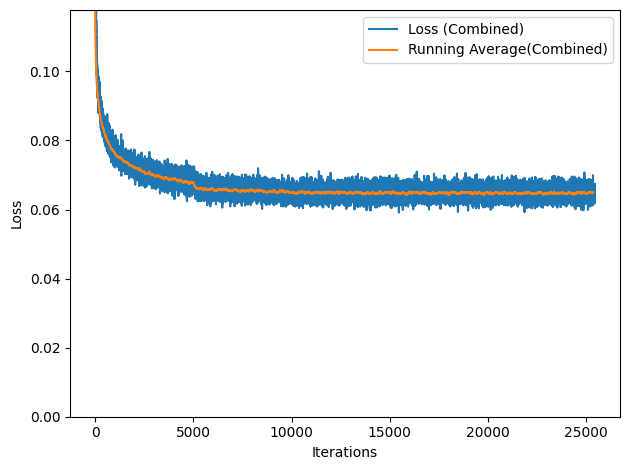

In [7]:
if not load_model:
    log_dict = train(num_epochs=NUM_EPOCHS, model=model, 
                            optimizer=optimizer, scheduler=scheduler, 
                            device=device, train_loader=train_loader,
                            loss_fn=loss_fn)
    plot_training_loss(log_dict['combined_loss'], NUM_EPOCHS, label="(Combined)")

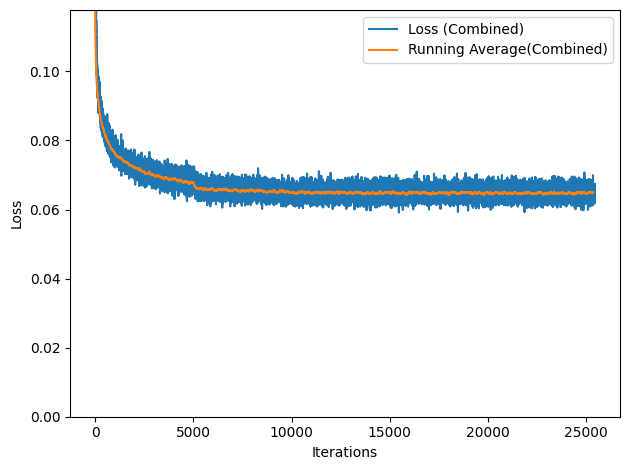

In [8]:
if not load_model:
    plot_training_loss(log_dict['combined_loss'], NUM_EPOCHS, label="(Combined)")

In [9]:
model.load_state_dict(torch.load('vae_celeba.pt'))

<All keys matched successfully>

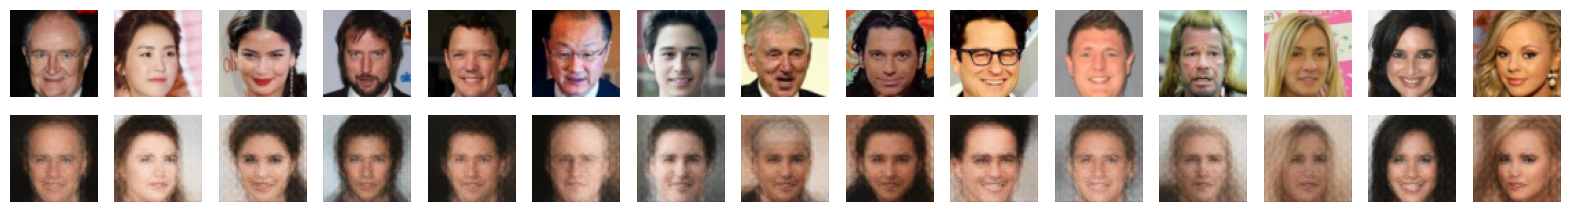

In [10]:
plot_generated_images(data_loader=train_loader, model=model, device=device)           

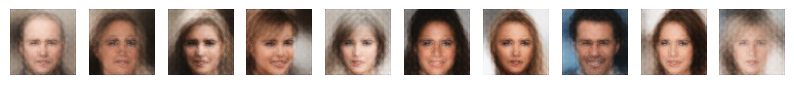

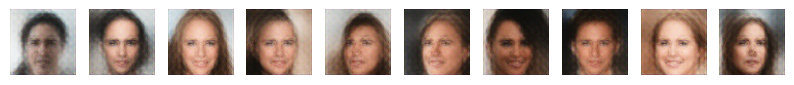

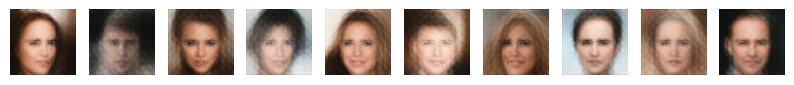

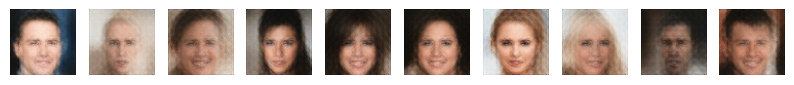

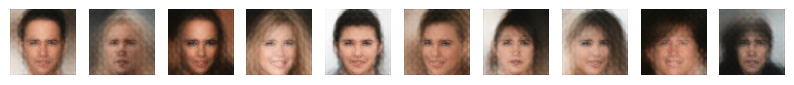

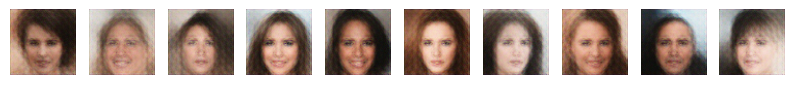

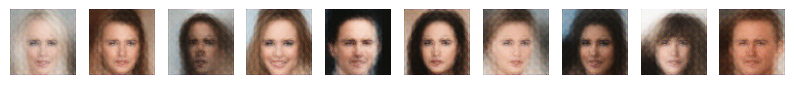

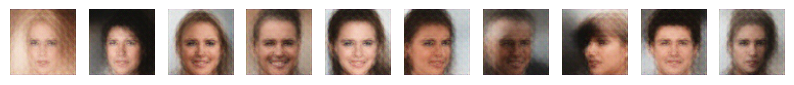

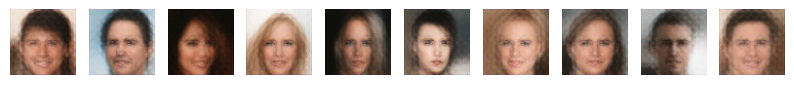

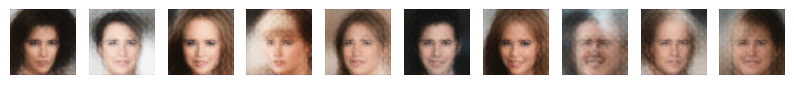

In [11]:
for i in range(10):
    plot_images_sampled_from_vae(model=model, device=device, latent_size=128)

In [12]:
# Limit to 10k images
all_embeddings = torch.zeros((10064, 128))
num_images = 0

for images, labels in train_loader:
    
    if num_images >= 10_000:
        break
    
    begin = num_images
    end = begin + images.size(0)
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        mu, log_var = model.encode(images)
        z = model.reparameterize(mu, log_var).to('cpu')

    all_embeddings[begin:end] = z
    num_images = end

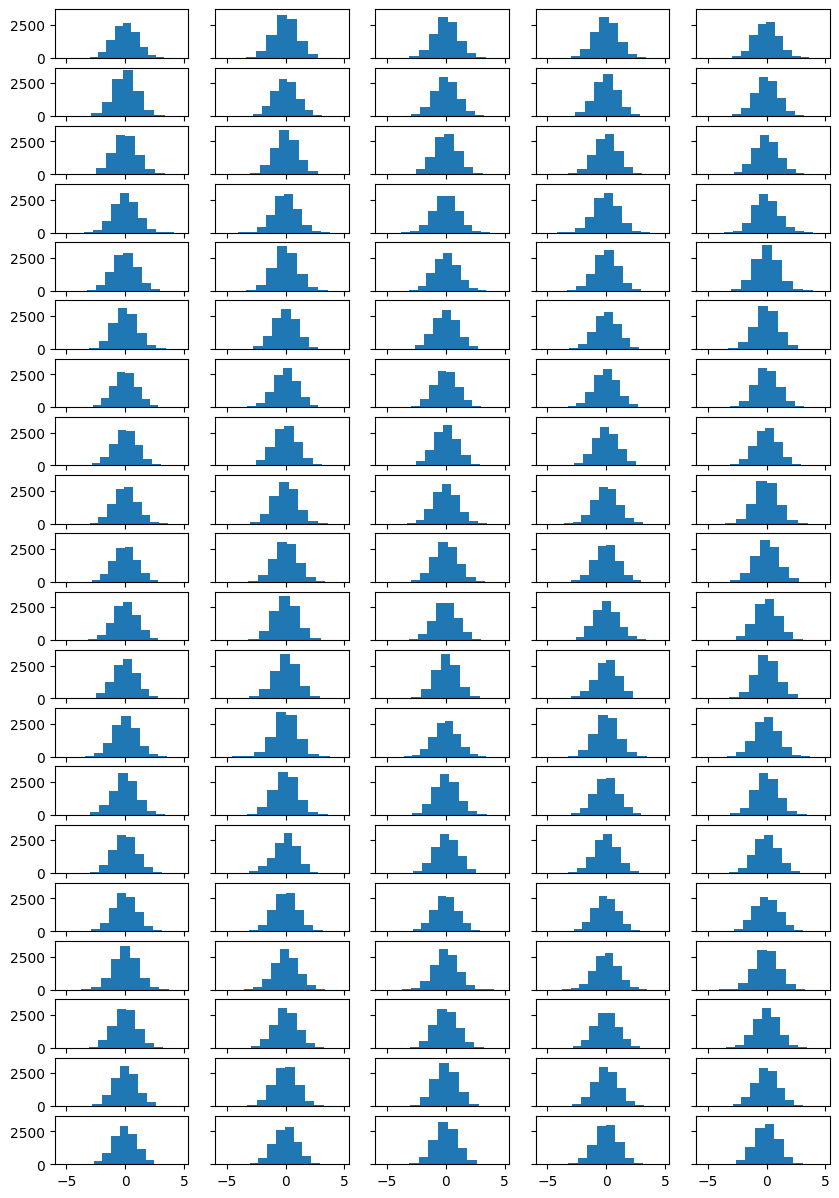

In [13]:
plot_embedding_hist(all_embeddings)

In [14]:
def compute_average_faces(feature_idx, image_dim, data_loader, device, model):
    avg_img_with_feat = torch.zeros(image_dim, dtype=torch.float32)
    avg_img_without_feat = torch.zeros(image_dim, dtype=torch.float32)

    num_img_with_feat = 0
    num_images_without_feat = 0

    for images, labels in data_loader:  
        idx_img_with_feat = labels[:, feature_idx].to(torch.bool)

        with torch.no_grad():
            if device is not None:
                images = images.to(device)
            
            mu, log_var = model.encode(images)
            embeddings = model.reparameterize(mu, log_var).to('cpu')            

        avg_img_with_feat += torch.sum(embeddings[idx_img_with_feat], axis=0)
        avg_img_without_feat += torch.sum(embeddings[~idx_img_with_feat], axis=0)
        num_img_with_feat += idx_img_with_feat.sum(axis=0)
        num_images_without_feat += (~idx_img_with_feat).sum(axis=0)

    avg_img_with_feat /= num_img_with_feat
    avg_img_without_feat /= num_images_without_feat
    
    return avg_img_with_feat, avg_img_without_feat

In [15]:
smiling_vector, not_smiling_vector = compute_average_faces(
    feature_idx=31, # smiling
    image_dim=128,
    data_loader=train_loader,
    device=device,
    model=model)

In [16]:
example_image = images[8]

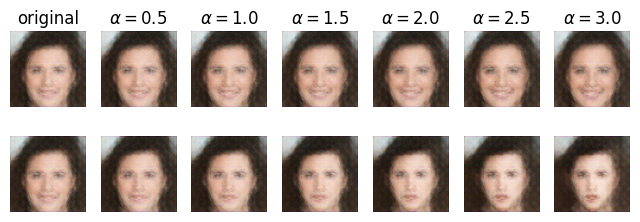

In [17]:
smiling_diff = (smiling_vector - not_smiling_vector)

example_image = example_image.unsqueeze(0).to(device)
with torch.no_grad():
    mu, log_var = model.encode(example_image)
    encoded = model.reparameterize(mu, log_var).squeeze(0).to('cpu') 

plot_modified_faces(original=encoded,
                    decoding_fn=model.decode,
                    device=device,
                    diff=smiling_diff)

In [18]:
eyeglasses_vector, not_eyeglasses_vectore = compute_average_faces(
    feature_idx=15, # eyeglasses
    image_dim=128,
    data_loader=train_loader,
    device=device,
    model=model)

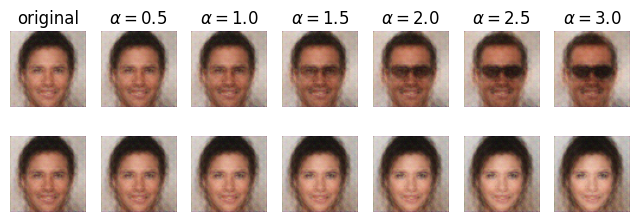

In [44]:
example_image = images[7]
eyeglasses_diff = (eyeglasses_vector - not_eyeglasses_vectore)

example_image = example_image.unsqueeze(0).to(device)
with torch.no_grad():
    mu, log_var = model.encode(example_image)
    encoded = model.reparameterize(mu, log_var).squeeze(0).to('cpu') 

plot_modified_faces(original=encoded,
                    decoding_fn=model.decode,
                    device=device,
                    diff=eyeglasses_diff)
